In [2]:
from utils.base_data_handler import BaseDataHandler

california_handler = BaseDataHandler(path='2025-12-09/california_housing_data.csv')
california_handler.try_clean_column_names()
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        20640 non-null  float64
 1   house_age      20640 non-null  float64
 2   ave_rooms      20640 non-null  float64
 3   ave_bedrms     20640 non-null  float64
 4   population     20640 non-null  float64
 5   ave_occup      20640 non-null  float64
 6   latitude       20640 non-null  float64
 7   longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [3]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np

# --- 1. Coastline Distance Calculation ---
# Crescent City, Point Arena, SF outer coast, Monterey, Santa Barbara, LA, San Diego
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])

# Quadratic fit: lon = a*lat^2 + b*lat + c
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)
def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def coast_distance(lat, lon):
    # Approximates the longitude on the fitted coastline at the given latitude
    coast_lon = _coast_lon(lat)
    # This distance is an approximation using Haversine between the point and the coast projection
    return haversine(lat, lon, lat, coast_lon) 

# Add dist_to_coast column
_ = california_handler.try_add_col(target_col="dist_to_coast", func=lambda row: coast_distance(row['latitude'],row['longitude']))

relations_of_interest = {

    'est_households' : ('population', 'ave_occup'),
    'rooms_per_households' : ('ave_rooms', 'est_households'),
    'pop_per_households' : ('population', 'est_households'),
    'bedrms_per_household' : ('ave_bedrms', 'est_household'),

    # Existing Ratios (Adjusted for completeness/avoiding duplicates)
    'income_per_population' : ('med_inc','population'),
    'income_per_house_age' : ('med_inc','house_age'),
    'income_per_dist_coast' : ('med_inc', 'dist_to_coast'),
    'income_per_bedrms': ('med_inc', 'ave_bedrms'),
    'income_per_rooms': ('med_inc', 'ave_rooms'),
    'income_per_occup': ('med_inc','ave_occup'),
    'income_per_households' : ('med_inc', 'est_households'),
    'bedrms_per_rooms': ('ave_bedrms','ave_rooms'),
    'rooms_per_age': ('ave_rooms','house_age'),
    'rooms_per_capita': ('ave_rooms','population'),
    
    # NEW/Modified Ratios
    'rooms_per_person': ('ave_rooms', 'ave_occup'), 
    'house_density': ('ave_occup', 'ave_rooms'), 
    'income_per_capita': ('med_inc', 'ave_occup'), 
    'pop_per_house_age': ('population', 'house_age'), 
    'rooms_vs_bedrooms': ('ave_rooms', 'ave_bedrms'),
    'age_per_dist_coast': ('house_age', 'dist_to_coast'),
}

for new_col, (col1, col2) in relations_of_interest.items():
    # Execute all ratio additions using the small constant (1e-6) to handle near-zero denominators
    california_handler.try_add_col(new_col, lambda r: r[col1] / (r[col2] + 1e-6))

# --- 4. Polynomial / Transformation Features ---

# Polynomial Term
california_handler.try_add_col('ave_rooms_squared', lambda r: r['ave_rooms'] **2)

# Log Transformations (Useful for highly skewed features)
california_handler.try_add_col('log_med_inc', lambda r: np.log1p(r['med_inc']))
california_handler.try_add_col('log_population', lambda r: np.log1p(r['population']))


# --- 5. Spatial Feature (Interaction) ---

# Latitude-Longitude Interaction (Captures unique spatial locations)
california_handler.try_add_col('lat_times_long', lambda r: r['latitude'] * r['longitude'])

# --- Final Check ---
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   med_inc                20640 non-null  float64
 1   house_age              20640 non-null  float64
 2   ave_rooms              20640 non-null  float64
 3   ave_bedrms             20640 non-null  float64
 4   population             20640 non-null  float64
 5   ave_occup              20640 non-null  float64
 6   latitude               20640 non-null  float64
 7   longitude              20640 non-null  float64
 8   med_house_val          20640 non-null  float64
 9   dist_to_coast          20640 non-null  float64
 10  est_households         20640 non-null  float64
 11  rooms_per_households   20640 non-null  float64
 12  pop_per_households     20640 non-null  float64
 13  income_per_population  20640 non-null  float64
 14  income_per_house_age   20640 non-null  float64
 15  in

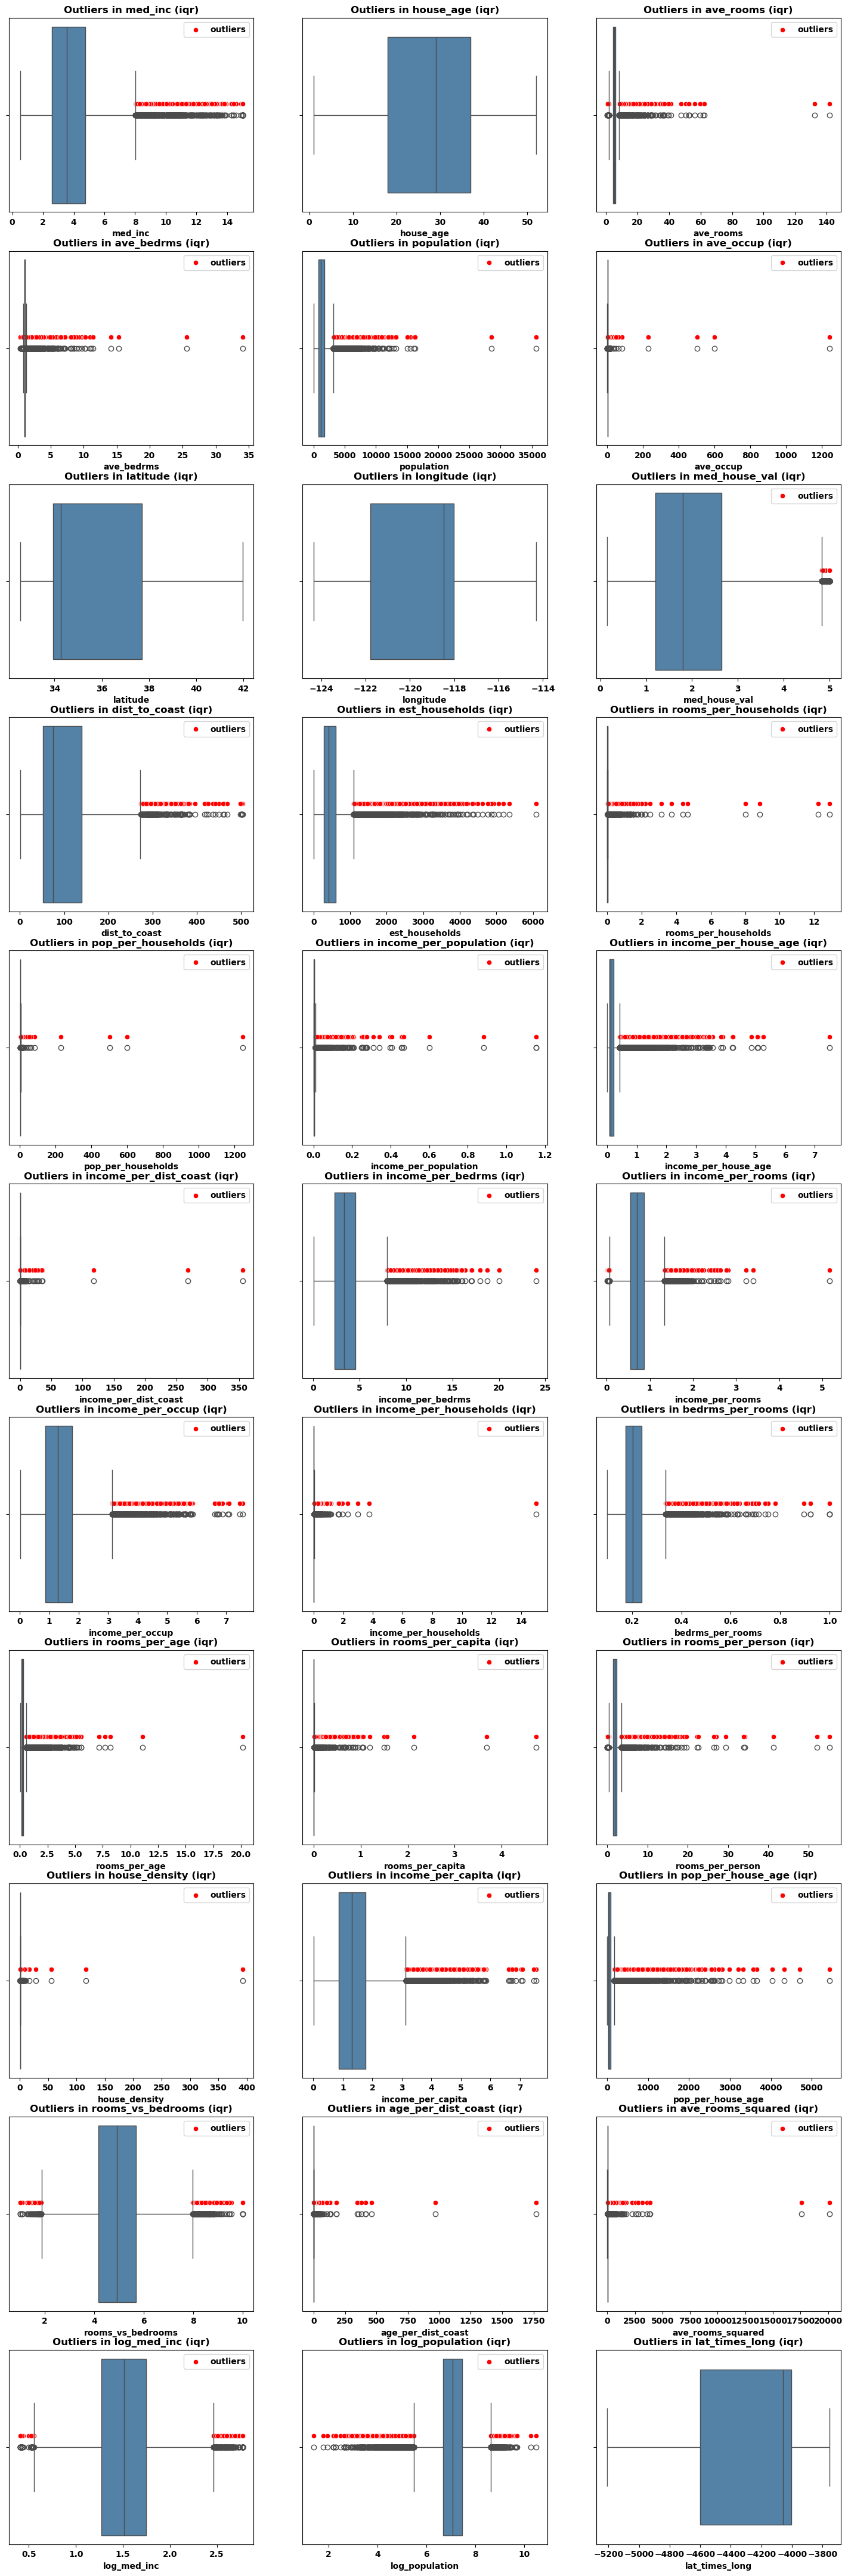

In [4]:
fig,ax = california_handler.get_outlier_case_study(method='iqr')

In [5]:
mask = california_handler.get_outliers_df(lower_percentile=.005, upper_percentile=.995)                 # DataFrame of flags
row_mask = mask.any(axis=1)                                 # collapse to single Series
california_handler.df = california_handler.df[~row_mask]    # keep only non-outliers
california_handler.df.dropna(inplace=True)
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18666 entries, 0 to 20639
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   med_inc                18666 non-null  float64
 1   house_age              18666 non-null  float64
 2   ave_rooms              18666 non-null  float64
 3   ave_bedrms             18666 non-null  float64
 4   population             18666 non-null  float64
 5   ave_occup              18666 non-null  float64
 6   latitude               18666 non-null  float64
 7   longitude              18666 non-null  float64
 8   med_house_val          18666 non-null  float64
 9   dist_to_coast          18666 non-null  float64
 10  est_households         18666 non-null  float64
 11  rooms_per_households   18666 non-null  float64
 12  pop_per_households     18666 non-null  float64
 13  income_per_population  18666 non-null  float64
 14  income_per_house_age   18666 non-null  float64
 15  income_

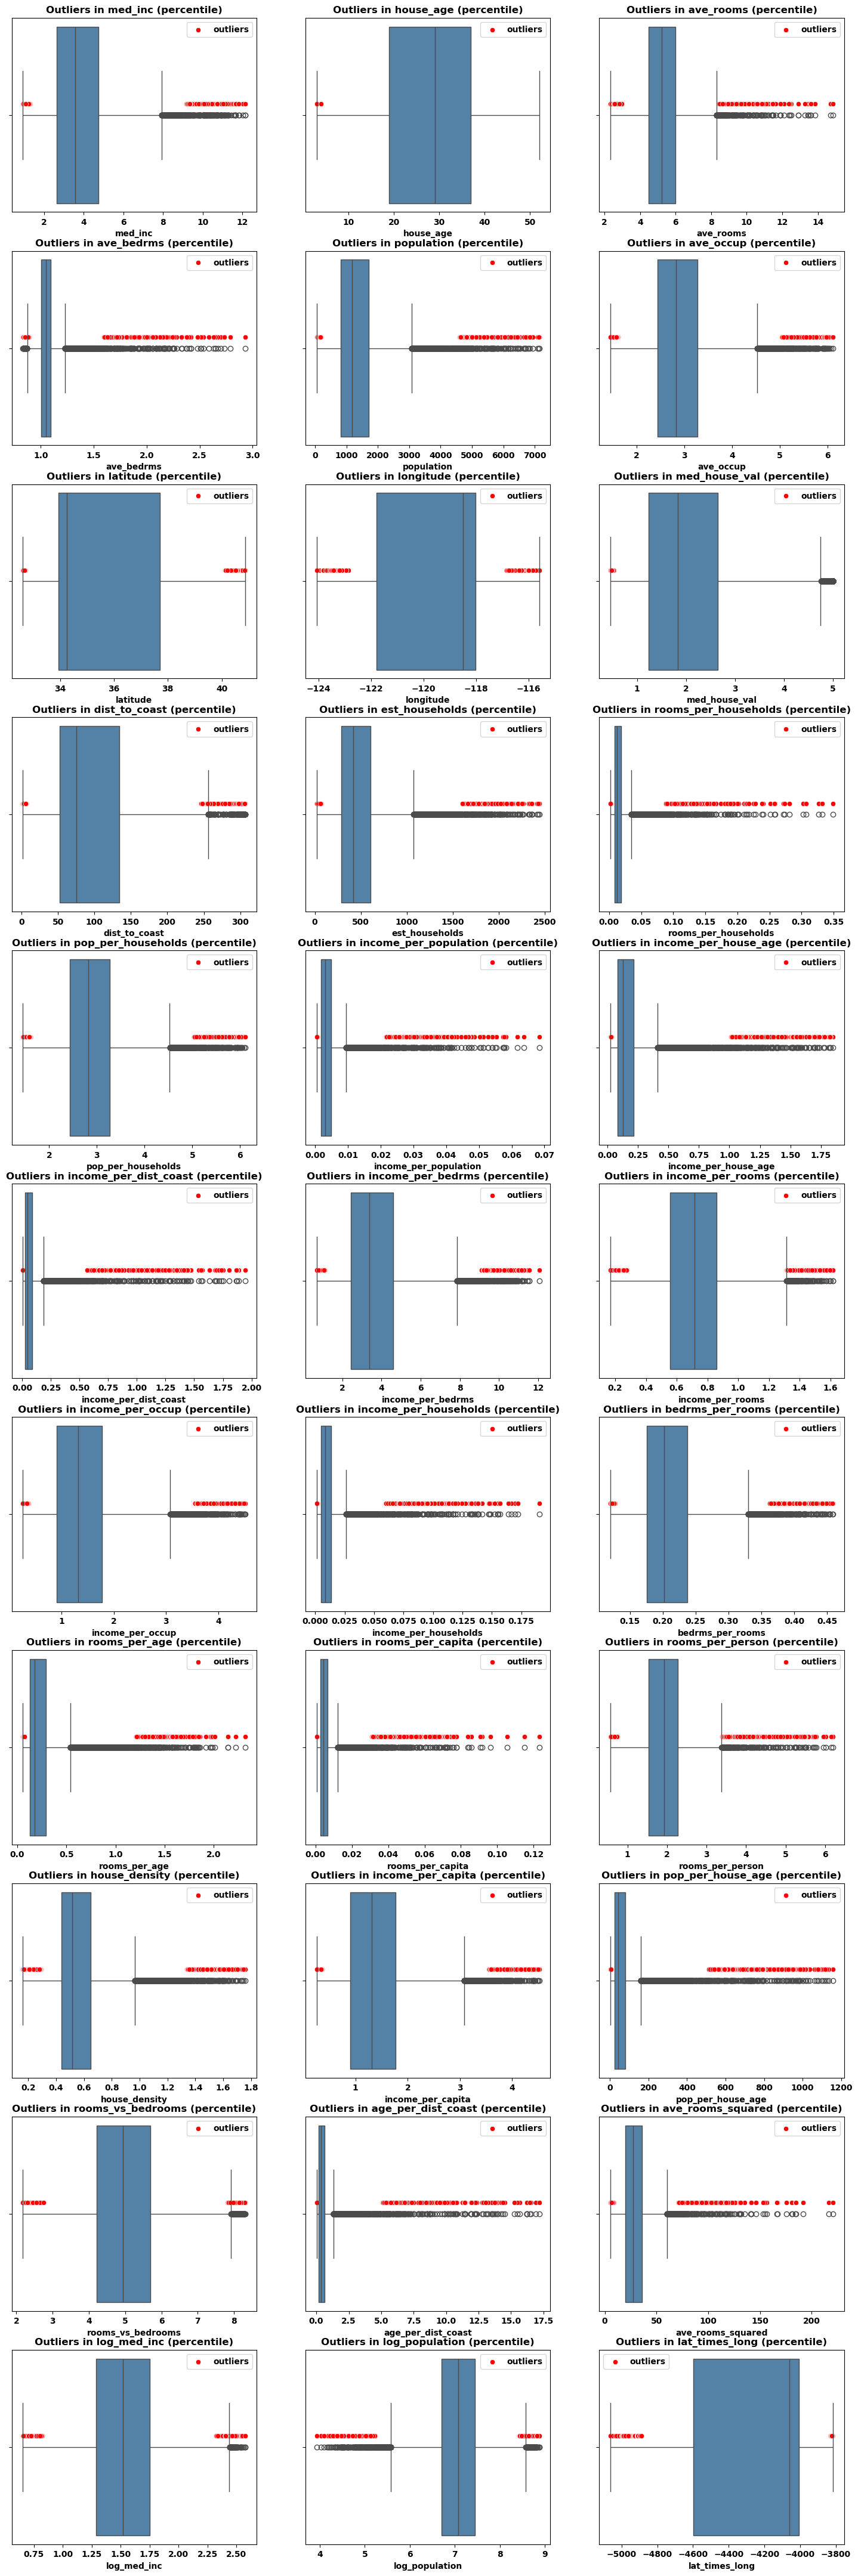

In [6]:
fig,ax = california_handler.get_outlier_case_study()


In [7]:
import optuna
import numpy as np
import xgboost as xgb
from utils import functions
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback, CatBoostPruningCallback

# --- 1. Data Setup and Log Transformation ---
X,y = california_handler.get_training_data(target="med_house_val")
# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1. Split Data for Tuning (Train/Validation)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

scaler = RobustScaler()
# Fit scaler on the full training set (X_train) to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale all subsets used for tuning
X_train_part_scaled = scaler.transform(X_train_part)
X_valid_scaled = scaler.transform(X_valid)

# Apply Log Transformation to Target Variables (y)
y_train_log = np.log1p(y_train_part)
y_valid_log = np.log1p(y_valid)
y_train_full_log = np.log1p(y_train)

# --- 2. DMatrix Creation (For XGBoost Only) ---
dtrain_part = xgb.DMatrix(X_train_part_scaled, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log)
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_full_log)
dtest = xgb.DMatrix(X_test_scaled)

def objective_xgb(trial):
    ## --- 2. Search Space ---
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cpu",
        "verbosity": 0,
        "eval_metric": "rmse",
        
        # Hyperparameters to optimize
        'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
    }

    ## --- 3. Setup Pruning Callback ---
    # Monitors the RMSE of the validation set (named 'validation')
    pruning_callback = XGBoostPruningCallback(trial, "validation-rmse")

    ## --- 4. Run Training on Partial Data ---
    model = xgb.train(
        params,
        dtrain_part,
        num_boost_round=1000,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=50,
        callbacks=[pruning_callback],
        verbose_eval=False
    )

    # Return the best score (RMSE on log-prices)
    trial.set_user_attr("best_iteration", model.best_iteration)
    return model.best_score

def objective_lgbm(trial):
    params = {
        'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }

    pruning_callback = LightGBMPruningCallback(trial, 'rmse')

    model = LGBMRegressor(**params)

    model.fit(
        X_train_part_scaled, y_train_log,
        eval_set=[(X_valid_scaled, y_valid_log)],
        eval_metric='rmse',
        callbacks=[pruning_callback, early_stopping(50, verbose=False)],
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.best_score_['valid_0']['rmse']


def objective_cat(trial):
    params = {
        'objective': 'RMSE', 'verbose': 0, 'random_seed': 42,
        'iterations': trial.suggest_int('iterations', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, .95),
        'rsm': trial.suggest_float('rsm', 0.6, 1.0), # Feature Fraction
        'allow_writing_files': False,
    }

    purning_callback = CatBoostPruningCallback(trial, 'RMSE')

    model = CatBoostRegressor(**params)

    model.fit(
        X_train_part_scaled, y_train_log,
        eval_set=[(X_valid_scaled, y_valid_log)],
        callbacks=[purning_callback],
        early_stopping_rounds=50,
        verbose=0
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.get_best_score()['validation']['RMSE']

e:\Luca\Machine-Learning course\keggle_entry_12_2025\.conda_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# --- Optimization Run ---
print("Optimizing XGBoost (using DMatrix)...")
study_xgb = optuna.create_study(direction="minimize", study_name="XGBoost_California")
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=False)

[I 2025-12-09 18:29:14,023] A new study created in memory with name: XGBoost_California


Optimizing XGBoost (using DMatrix)...


[I 2025-12-09 18:29:14,797] Trial 0 finished with value: 0.1217021139909479 and parameters: {'n_estimators': 1928, 'learning_rate': 0.08230570430900963, 'max_depth': 8, 'subsample': 0.7871809878033171, 'colsample_bytree': 0.8110301052711383, 'min_child_weight': 2, 'lambda': 0.0044274628553448445, 'alpha': 0.0002148764564865711}. Best is trial 0 with value: 0.1217021139909479.
[I 2025-12-09 18:29:19,235] Trial 1 finished with value: 0.11879743136358106 and parameters: {'n_estimators': 933, 'learning_rate': 0.028606686519868512, 'max_depth': 9, 'subsample': 0.9003120161630344, 'colsample_bytree': 0.9335124271876581, 'min_child_weight': 1, 'lambda': 0.14279785860474378, 'alpha': 0.0002449134367046624}. Best is trial 1 with value: 0.11879743136358106.
[I 2025-12-09 18:29:19,943] Trial 2 finished with value: 0.12258986822947521 and parameters: {'n_estimators': 1329, 'learning_rate': 0.04286224989350359, 'max_depth': 4, 'subsample': 0.7991444442065844, 'colsample_bytree': 0.7482045018357713,

In [9]:
print("Optimizing LightGBM (using DMatrix)...")
study_lgbm = optuna.create_study(direction="minimize", study_name="LightGBM_California")
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=False)

[I 2025-12-09 18:29:32,606] A new study created in memory with name: LightGBM_California


Optimizing LightGBM (using DMatrix)...


[I 2025-12-09 18:29:33,859] Trial 0 finished with value: 0.12078271493270216 and parameters: {'n_estimators': 1518, 'learning_rate': 0.020882225570147645, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 13, 'colsample_bytree': 0.7608253822699093, 'subsample': 0.6591996198299773, 'reg_alpha': 1.0555884485594806e-05, 'reg_lambda': 0.04161063953260792}. Best is trial 0 with value: 0.12078271493270216.
[I 2025-12-09 18:29:34,608] Trial 1 finished with value: 0.12147367054805813 and parameters: {'n_estimators': 1973, 'learning_rate': 0.04807602899619542, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 17, 'colsample_bytree': 0.8673098091950746, 'subsample': 0.9296276289147362, 'reg_alpha': 1.8671506694068164e-06, 'reg_lambda': 0.006938359499430802}. Best is trial 0 with value: 0.12078271493270216.
[I 2025-12-09 18:29:35,159] Trial 2 finished with value: 0.12529662231013633 and parameters: {'n_estimators': 1793, 'learning_rate': 0.032851106597675976, 'num_leaves': 23, 'max_dept

In [10]:
print("Optimizing CatBoost (using DMatrix)...")
study_cat = optuna.create_study(direction="minimize", study_name="CatBoost_California")
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=False)

[I 2025-12-09 18:29:48,926] A new study created in memory with name: CatBoost_California
C:\Users\Luca\AppData\Local\Temp\ipykernel_6104\3675839270.py:126: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  purning_callback = CatBoostPruningCallback(trial, 'RMSE')


Optimizing CatBoost (using DMatrix)...


[I 2025-12-09 18:29:58,078] Trial 0 finished with value: 0.1185079915235526 and parameters: {'iterations': 1142, 'learning_rate': 0.06784413576562705, 'depth': 8, 'l2_leaf_reg': 1.075162303011914, 'subsample': 0.6307128119177742, 'rsm': 0.9832009654420066}. Best is trial 0 with value: 0.1185079915235526.
[I 2025-12-09 18:30:01,164] Trial 1 finished with value: 0.12005867651752954 and parameters: {'iterations': 1033, 'learning_rate': 0.08849225191855549, 'depth': 5, 'l2_leaf_reg': 2.74611830376069, 'subsample': 0.7426978796830235, 'rsm': 0.955754660768127}. Best is trial 0 with value: 0.1185079915235526.
[I 2025-12-09 18:30:03,050] Trial 2 finished with value: 0.12483086204741585 and parameters: {'iterations': 841, 'learning_rate': 0.09084074240186644, 'depth': 4, 'l2_leaf_reg': 9.351832887440146, 'subsample': 0.6400625407096954, 'rsm': 0.6584463470779454}. Best is trial 0 with value: 0.1185079915235526.
[I 2025-12-09 18:30:11,989] Trial 3 finished with value: 0.119567726573222 and para

xgb n rounds: 987
lgbm n rounds: 730
cat n rounds: 1140

5. Assembling Best Models for Stacking...
   -> Stacking Model Trained Successfully.

--- FINAL STACKING ENSEMBLE REPORT ---
Base Models' Avg RMSE (Log): 0.1190
Stacking Ensemble RMSE (Original Price Scale): 0.3884
---------------------------------------


e:\Luca\Machine-Learning course\keggle_entry_12_2025\.conda_gpu\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


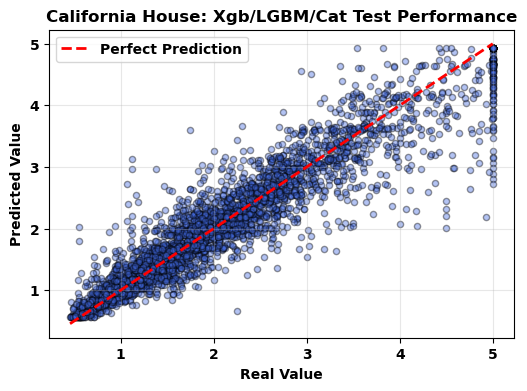

In [11]:
# --- XGBoost ---
best_xgb_params = study_xgb.best_params.copy()
xgb_n_rounds = max(1, study_xgb.best_trial.user_attrs.get('best_iteration', 2000))
print(f'xgb n rounds: {xgb_n_rounds}')
best_xgb_params.update({
    'n_estimators': xgb_n_rounds,
    "n_jobs": -1,
    "device": "cuda",
    "seed" : 42})

# --- LightGBM ---
best_lgbm_params = study_lgbm.best_params.copy()
lgbm_n_rounds = max(1, study_lgbm.best_trial.user_attrs.get('best_iteration', 2000))
print(f'lgbm n rounds: {lgbm_n_rounds}')
best_lgbm_params.update({
    "n_estimators": lgbm_n_rounds,
    'n_jobs':-1,
    'verbose':-1,
    'random_state':42})

# --- CatBoost ---
best_cat_params = study_cat.best_params.copy()
cat_n_rounds = max(1, study_cat.best_trial.user_attrs.get('best_iteration', 2000))
print(f'cat n rounds: {cat_n_rounds}')
best_cat_params.update({
    "iterations": cat_n_rounds, 
    "verbose": 0, 
    "random_state": 42, 
    "allow_writing_files": False})

print("\n5. Assembling Best Models for Stacking...")
estimators = [
    ('xgb', xgb.XGBRegressor(**best_xgb_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    ('cat', CatBoostRegressor(**best_cat_params))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    cv=5,
    n_jobs=-1
)

# 4. Train the Stacker on the full SCALED and LOG-TRANSFORMED training data
# This is the final and most critical step.
stacking_model.fit(X_train_scaled, y_train_full_log)
print("   -> Stacking Model Trained Successfully.")

# --- 6. Prediction and Evaluation ---

# 1. Predict on the scaled test set
# The prediction output is in the log scale
y_pred_log_stacked = stacking_model.predict(X_test_scaled)

# 2. Inverse Transform predictions to original scale
y_pred_final_stacked = np.expm1(y_pred_log_stacked) 

# 3. Evaluate the final result
final_stacking_rmse = root_mean_squared_error(y_test, y_pred_final_stacked)

print("\n--- FINAL STACKING ENSEMBLE REPORT ---")
print(f"Base Models' Avg RMSE (Log): {(study_xgb.best_value + study_lgbm.best_value + study_cat.best_value) / 3:.4f}")
print(f"Stacking Ensemble RMSE (Original Price Scale): {final_stacking_rmse:.4f}")
print("---------------------------------------")


fig, ax = functions.get_prediction_graph({'California House: Xgb/LGBM/Cat':(None, y_pred_final_stacked)}, y_test=y_test)